# 6G and Artificial Intelligence With Security Problems
## 6G solutions with Adversarial Machine Learning Attacks: Millimeter Wave Beam Prediction Use-Case

### 1. Introduction to 6G
6G is the next generation for the communication systems. In recent years, machine learning algorithms have been applied widely in various fields such as health, transportation, and the autonomous car. The predictive algorithms will be used in 6G problems. With the rapid developments of deep learning techniques, it is critical to take the security concern into account to apply the algorithms. While machine learning offers significant advantages for 6G, AI models' security is ignored. Since it has many applications in the real world, security is a vital part of the algorithms. This post has proposed a mitigation method for adversarial attacks against 6G machine learning models with adversarial learning. The main idea behind adversarial attacks against machine learning models is to produce faulty results by manipulating trained deep learning models for 6G applications. 

Up to 4G, time-frequency domain technology has been explored to increase overall system capacity. The recent developments in 5G and beyond technologies support emerging applications such as smart homes, vehicular networks, augmented reality (AR), virtual reality (VR) with unprecedented rates enabled by recent advances in massive multiple-input multiple-output (MIMO), mmWave communications, network slicing, small cells, and Internet of things (IoT). These complex structures of 5G and beyond technologies  can be captured by using **data-driven approach** machine learning (ML) algorithm. The strong learning, reasoning, intelligent recognition abilities of ML allow the network structure to train and adapt itself to support diverse demands of the systems without human intervention.

On the other hand, 6G is vulnerable for the adversarial machine learning attacks. Figure shows an attack scenario. The attacker gets an legitimate input, $\mathbf{x}$, creates a noise vector with an $\epsilon$ budget $\eta = \epsilon \cdot sign(\nabla_x \ell(\mathbf{\theta},\mathbf{x},y))$, sums the input instance and the craftily designed noise to create adversarial input $\mathbf{x}^{adv} = \mathbf{x} + \eta$.

![Adversarial Machine Learning Attack in 6G](blacksea_paper/img/adv-ml.png)

### 2. Adversarial Machine Learning
Adversarial machine learning is an attack technique that attempts to fool neural network models by supplying craftily manipulated input with a small difference. The obvious intention is to produce a failure in a neural network.

There are many attacking methods for deep learning models, and FGSM is the most straightforward and powerful attack type. FGSM works by utilizing the gradients of the neural network to create an adversarial example to evade the model. For an input instance $\mathbf{x}$.

\begin{equation}
	\mathbf{x}^{adv} = \mathbf{x} + \epsilon \cdot sign(\nabla_x \ell(\mathbf{\theta},\mathbf{x},y))
\end{equation}

![FGSM attack](blacksea_paper/img/fgsm_detail.png)

### 3. Solution: Adversarial Training

Adversarial training is a widely recommended defense that implies generating adversarial instances using the gradient of the victim classifier, and then re-training the model with the adversarial instances and their respective labels. This technique has demonstrated to be efficient in defending models from adversarial attacks. 

Let us first think a common classification problem with a training instances $X \in \mathbb{R}^{m \times n}$ of dimension $d$, a label space $Y$ We assume the classifier $h_\theta$ has been trained to minimize a loss function $\ell$as follows:

\begin{equation}
	\label{eq:cost-func}
	\underset{\theta}{min}\frac{1}{m} \sum_{i=1}^{m} \ell(h_\theta(\mathbf{x}_i,y_i))
\end{equation}

The following figure shows the diagram of **RF beamforming codeword adversarial training**.

![FGSM attack](blacksea_paper/img/deepmimo_adv_learning.png)

### 4. Let’s coding

We import the usual standard libraries to build a deep learning model to predict RF beamforming codeword.

In [1]:
import tensorflow as tf
from scipy.io import loadmat, savemat
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint
import pickle 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

In this work, we will use publicly avaliable [DeepMIMO dataset](https://www.deepmimo.net) to attack RF beam forming prediction model. We will use FGSM attack, and **Mean Squared Error** loss function for the input manipulation. Our FGSM attack implementation is here.

In [2]:
loss_object = tf.keras.losses.MeanSquaredError()

def fgsm(model, input_instance, label, n_BS,n_beams, epsilon =0.01):
    tensor_input_instance = tf.convert_to_tensor(input_instance, dtype=tf.float32)
    adv_x = input_instance
    for idx in range(0, n_BS*n_beams-2, n_beams):
        with tf.GradientTape() as tape:
            tmp_label = label[:, idx:idx + n_beams]
            tape.watch(tensor_input_instance)
            prediction = model(tensor_input_instance)
            loss = loss_object(tmp_label, prediction)
            gradient = tape.gradient(loss, tensor_input_instance)
            signed_grad = tf.sign(gradient)
            adv_x = adv_x + eps * signed_grad
    return adv_x

## The parameters in our scenario

| Parameter      | Value |
| ----------- | ----------- |
| Num of BS      | 4       |
| Train Test Split   | 0.8        |
| Number of beams | 512 |
| Activation Function | ReLU|
| Loss| Mean Squared Error|
| Optimizer| Rmsprop|

In [3]:
# Reading input and output sets generated from MATLAB
# with DeepMIMO generator http://www.deepmimo.net
In_set_file=loadmat('DLCB_dataset/DLCB_input.mat')
Out_set_file=loadmat('DLCB_dataset/DLCB_output.mat')

In_set=In_set_file['DL_input']
Out_set=Out_set_file['DL_output']

# Parameter initialization
num_user_tot=In_set.shape[0]

DL_size_ratio = .8
count=0
num_tot_TX=4
num_beams=512

# The train procedure

In [4]:
def train(In_train, Out_train, In_test, Out_test,
          nb_epoch, batch_size,dr,
          num_hidden_layers, nodes_per_layer,
          loss_fn,n_BS,n_beams):
    
    in_shp = list(In_train.shape[1:])

    AP_models = []
    for idx in range(0, n_BS*n_beams-2, n_beams):
        idx_str = str(idx / n_beams + 1)
        act_func = 'relu'
        model = Sequential()
        model.add(Dense(100, input_dim=in_shp[0], activation=act_func))
        model.add(Dense(100, activation=act_func))
        model.add(Dense(100, activation=act_func))
        model.add(Dense(100, activation=act_func))
        model.add(Dense(n_beams, activation=act_func))
        model.compile(loss=loss_fn, optimizer='rmsprop', metrics=['mean_squared_error'])
        
        history = model.fit(In_train,
                            Out_train[:, idx:idx + n_beams],
                            batch_size=batch_size,
                            epochs=nb_epoch,
                            verbose=0,
                            validation_data=(In_test, Out_test[:,idx:idx + n_beams]))
        
        filehandler = open('history.pkl', 'wb') 
        pickle.dump(history.history, filehandler)
        filehandler.close()
        
        AP_models.append(model)
    return AP_models

# Training process (Normal Behaviour)

Here we will train the RF beamforming codeword prediction model with out any attacker. 

In [5]:
count=count+1
DL_size=int(num_user_tot*DL_size_ratio)

np.random.seed(2016)
n_examples = DL_size
num_train  = int(DL_size * 0.8)
num_test   = int(num_user_tot*.2)

train_index = np.random.choice(range(0,num_user_tot), size=num_train, replace=False)
rem_index = set(range(0,num_user_tot))-set(train_index)
test_index= list(set(np.random.choice(list(rem_index), size=num_test, replace=False)))

In_train = In_set[train_index]
In_test =  In_set[test_index] 

Out_train = Out_set[train_index]
Out_test = Out_set[test_index]

#In_train, In_test, Out_train, Out_test =  train_test_split(In_set, Out_set, test_size=0.33)

# Learning model parameters
nb_epoch = 10    
batch_size = 100  
dr = 0.05                  # dropout rate  
num_hidden_layers=4
nodes_per_layer=In_train.shape[1]
loss_fn='mean_squared_error'

eps = 2.0 * 16.0 / 255.0


# Model training
AP_models = train(In_train, Out_train, In_test, Out_test,
                                      nb_epoch, batch_size,dr,
                                      num_hidden_layers, nodes_per_layer,
                                      loss_fn,num_tot_TX,num_beams)
# Model running/testing
DL_Result={}
mse_list = []
for id in range(0,num_tot_TX,1): 
    beams_predicted=AP_models[id].predict( In_test, batch_size=10, verbose=0)

    DL_Result['TX'+str(id+1)+'Pred_Beams']=beams_predicted
    DL_Result['TX'+str(id+1)+'Opt_Beams']=Out_test[:,id*num_beams:(id+1)*num_beams]

    mse = mean_squared_error(Out_test[:,id*num_beams:(id+1)*num_beams],beams_predicted)
    mse_list.append(mse)
print('mse:',np.mean(mse_list))

DL_Result['user_index']=test_index

mse: 0.00030647155448710575


# Attack the RF Beamforming Codeword Prediction Model

The RF beamforming prediction model's performance is quite good which is 0.00039. Now, we will attack the model with FGSM.

In [6]:
import warnings
warnings.filterwarnings('ignore')
# Model running/testing
DL_Result={}
mse_list = []
for id in range(0,num_tot_TX,1): 
    # !!!!! Attack generation !!!!
    In_test_adv = fgsm(AP_models[id], In_test,Out_test,num_tot_TX,num_beams,eps)
    beams_predicted=AP_models[id].predict( In_test_adv, batch_size=10, verbose=0)

    DL_Result['TX'+str(id+1)+'Pred_Beams']=beams_predicted
    DL_Result['TX'+str(id+1)+'Opt_Beams']=Out_test[:,id*num_beams:(id+1)*num_beams]

    mse = mean_squared_error(Out_test[:,id*num_beams:(id+1)*num_beams],beams_predicted)
    mse_list.append(mse)
print('mse:',np.mean(mse_list))

mse: 0.0151878763143215


## Adversarial Training
The attacked model's performance (i.e. $mse=0.01532$) is worst than the normal performance (i.e. $mse=0.00039$). Let's train the normal model with adversarial training.

In [7]:
# Model training function
def adv_train(In_train, Out_train, In_test, Out_test,
          nb_epoch, batch_size,dr,
          num_hidden_layers, nodes_per_layer,
          loss_fn,n_BS,n_beams, eps):
    
    in_shp = list(In_train.shape[1:])

    AP_models = []
    mcp_save = ModelCheckpoint('model.hdf5', save_best_only=True, verbose=0, 
                                   monitor='val_mean_squared_error', mode='min')
    
    for idx in range(0, n_BS*n_beams-2, n_beams):
        idx_str = str(idx / n_beams + 1)
        act_func = 'relu'
        model = Sequential()
        model.add(Dense(100, input_dim=in_shp[0], activation=act_func))
        model.add(Dense(100, activation=act_func))
        model.add(Dense(100, activation=act_func))
        model.add(Dense(100, activation=act_func))
        model.add(Dense(n_beams, activation=act_func))
        model.compile(loss=loss_fn, optimizer='rmsprop', metrics=['mean_squared_error'])
        
        history = model.fit(In_train,
                            Out_train[:, idx:idx + n_beams],
                            batch_size=batch_size,
                            epochs=nb_epoch,
                            verbose=0,
                            validation_data=(In_test, Out_test[:,idx:idx + n_beams]))
        
        callbacks = [mcp_save]
        for _ in range(10):
            In_train_adv = fgsm(model, In_train,Out_train, n_BS, n_beams)
            In_train_adv = np.concatenate((In_train, In_train_adv), axis=0)
            
            Out_train_adv = np.concatenate((Out_train, Out_train), axis=0)
            
            history = model.fit(In_train_adv,
                                Out_train_adv[:, idx:idx + n_beams],
                                batch_size=batch_size,
                                epochs=nb_epoch*3,
                                verbose=0,
                                callbacks=callbacks,
                                validation_data=(In_test, Out_test[:,idx:idx + n_beams]))
            model.load_weights('model.hdf5')
        
        AP_models.append(model)
    return AP_models

In [8]:
AP_models = adv_train(In_train, Out_train, In_test, Out_test,
                      nb_epoch, batch_size,dr,
                      num_hidden_layers, nodes_per_layer,
                      loss_fn,num_tot_TX,num_beams,eps)

In [9]:
# Model running/testing
DL_Result={}
mse_list = []
for id in range(0,num_tot_TX,1): 
    # !!!!! Attack generation !!!!
    In_test_adv = fgsm(AP_models[id], In_test,Out_test,num_tot_TX,num_beams,eps)
    beams_predicted=AP_models[id].predict( In_test_adv, batch_size=10, verbose=0)

    DL_Result['TX'+str(id+1)+'Pred_Beams']=beams_predicted
    DL_Result['TX'+str(id+1)+'Opt_Beams']=Out_test[:,id*num_beams:(id+1)*num_beams]

    mse = mean_squared_error(Out_test[:,id*num_beams:(id+1)*num_beams],beams_predicted)
    mse_list.append(mse)
print('mse:',np.mean(mse_list))

mse: 0.0006801871943259285


### All results
Now the RF beamforming codeword prediction model's performance under attack is better than the undefended model performance.

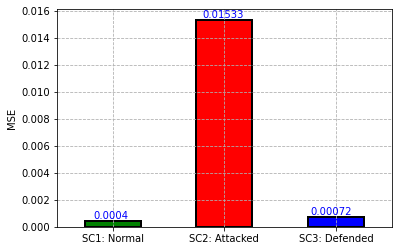

In [10]:
vals = [0.00039551136731949614,0.01532598592375935,0.0007175213740754419]
df = pd.DataFrame({'Scenario':['SC1: Normal','SC2: Attacked','SC3: Defended'],'vals':vals})
df.plot.bar(x='Scenario',y='vals', rot=0,color=['green', 'red','blue'], 
            edgecolor='black',legend='',linewidth=2)
plt.xlabel('')
ax = plt.gca()
for i, v in enumerate(vals):
    ax.text(-0.17+i*0.97, 0.0002 + v, str(np.round(vals[i],5)), color='blue')
plt.ylabel('MSE')
plt.grid(True, which="both", ls="--")
plt.show()